In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46241")
client

<Client: 'tcp://127.0.0.1:46241' processes=4 threads=8, memory=61.46 GiB>

In [2]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import fsspec
import zarr

import os
import xarray as xr
#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials

def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

# function for determining the memory footprint of an object

# ... from https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """
    This routine returns the in-memory size of an python object
    
    Returns:
    =======
    
    size: size of object & members.
    """
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

# Loading ECCO dataset: SSH, T, S, Density, OBP [native grid llc90]

In [4]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True);
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native')
# different prefixes on s3
# MZZ_day_mean_latlon
# MZZ_day_mean_native
# MZZ_mon_mean_latlon
# MZZ_mon_mean_native
# MZZ_snap_native

In [5]:
# show they are on the local disk 
np.sort(list(mzz_local_directory.glob('*json')))

array([PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ICE_FRONT_FLUX_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ICE_SHELF_FLUX_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_ADV_TEND_X_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_ADV_TEND_Y_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_DISS_TEND_X_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_DISS_TEND_Y_mon_me

In [6]:
# MZZ files have been downloaded. 
SSH_file = mzz_local_directory / 'SEA_SURFACE_HEIGHT_mon_mean_native_llc090_ECCOV4r5.json'
TS_file = mzz_local_directory / 'OCEAN_TEMPERATURE_SALINITY_mon_mean_native_llc090_ECCOV4r5.json'
OBP_file = mzz_local_directory / 'OCEAN_BOTTOM_PRESSURE_mon_mean_native_llc090_ECCOV4r5.json'
DENS_file = mzz_local_directory / 'OCEAN_DENS_STRAT_PRESS_mon_mean_native_llc090_ECCOV4r5.json'
#----PRINTING----#
print(SSH_file)
print(TS_file)
print(OBP_file)
print(DENS_file)

/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/SEA_SURFACE_HEIGHT_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_TEMPERATURE_SALINITY_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_BOTTOM_PRESSURE_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_DENS_STRAT_PRESS_mon_mean_native_llc090_ECCOV4r5.json


In [7]:
# Sea Surface Height -----------------------------------------------------
fs_SSH = fsspec.filesystem("reference",     
                       fo=str(SSH_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_SSH.asynchronous = True
store = zarr.storage.FsspecStore(fs_SSH)
ds_SSH = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})
# Temperature and Salinity -----------------------------------------------
fs_TS = fsspec.filesystem("reference",     
                       fo=str(TS_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_TS.asynchronous = True
store = zarr.storage.FsspecStore(fs_TS)
ds_TS = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})
# Ocean Bottom Pressure ---------------------------------------------------
fs_OBP = fsspec.filesystem("reference",     
                       fo=str(OBP_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_OBP.asynchronous = True
store = zarr.storage.FsspecStore(fs_OBP)
ds_OBP = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})
# Density ------------------------------------------------------------------
fs_DENS = fsspec.filesystem("reference",     
                       fo=str(DENS_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_DENS.asynchronous = True
store = zarr.storage.FsspecStore(fs_DENS)
ds_DENS = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})
#--------------------------------------------------------------------------

In [8]:
ds_SSH

<xarray.Dataset> Size: 571MB
Dimensions:    (time: 336, tile: 13, j: 90, i: 90, nb: 4, j_g: 90, i_g: 90,
                nv: 2)
Coordinates: (12/13)
  * time       (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
    XC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    ...         ...
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    time_bnds  (time, nv) datetime64[ns] 5kB dask.array<chunksize=(4, 2), meta=np.ndarray>
Dimensions without coordinates: nb, nv
Data variables:
    ETAN       (time, tile, j, i) float32 142MB dask.array<chunksize=(4, 13, 90, 90), meta=np.ndarray>
    SSH        (time, tile, j, i) float32 142MB dask.array<chunksize=(4, 13, 90, 90), meta=np.ndarray>
    SSHIBC     (time, tile, j, i) float32 142MB dask.array<chunksize=(4, 13, 90, 90), meta=np.ndarray>
    SSHNOIBC   (time, tile, j, i) float32 142MB dask.array<chunksize=(4, 13, 90, 90), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         d398608a-2721-11f0-9a8a-0a58a9feac02

In [9]:
itime = ((ds_SSH.time>= np.array(datetime.datetime(1993,1,1)).astype('datetime64[ns]')) & 
         (ds_SSH.time<= np.array(datetime.datetime(2017,12,31)).astype('datetime64[ns]')))
eta = ds_SSH.SSH[itime,:,:,:].compute()
lon_xc = ds_SSH.XC.compute()
lat_yc = ds_SSH.YC.compute()

<Figure size 1400x600 with 0 Axes>

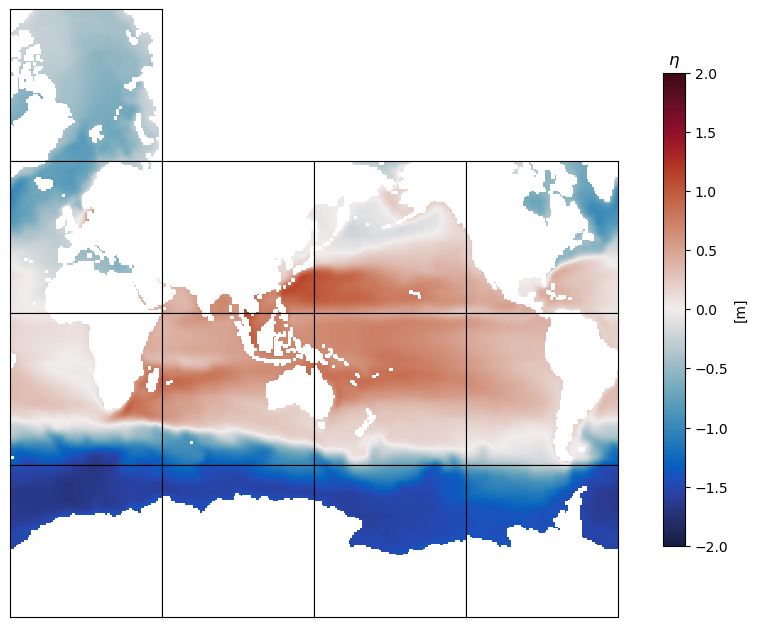

In [10]:
tsel = 0
plt.figure(figsize=[14,6]);
ecco.plot_tiles(eta[tsel,:,:,:], show_colorbar=True, 
                cmin=-2, cmax=2, 
                cmap=cmocean.cm.balance, 
                rotate_to_latlon=True, layout='latlon',
               show_tile_labels=False,show_cbar_label=True, cbar_label='[m]');
plt.title('$\eta$');

# Global SSH linear trends from ECCO v4r5

In [11]:
deltaT = int(ds_SSH.time[1]-ds_SSH.time[0])
deltaT # ns for a month!

2570400000000000

In [12]:
eta_trends = eta.polyfit(dim='time', deg=1, skipna=True)
# The slope (trend) is in the coefficient with degree 1
trend_slope = eta_trends['polyfit_coefficients'].sel(degree=1)*deltaT*12*1e3#*3.15576*1e16*1e3

<Figure size 1400x600 with 0 Axes>

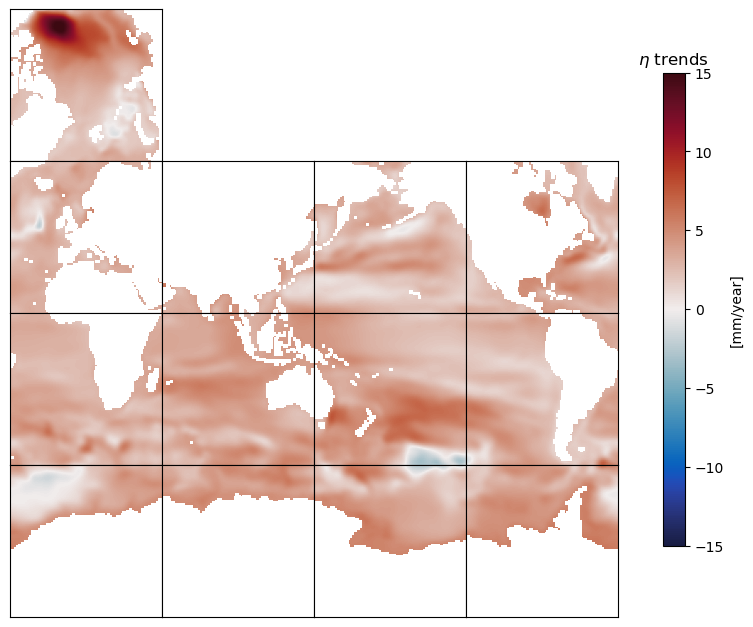

In [13]:
fig = plt.figure(figsize=[14,6]);
ecco.plot_tiles(trend_slope, show_colorbar=True, 
                cmin=-15, cmax=15, 
                cmap=cmocean.cm.balance, 
                rotate_to_latlon=True, layout='latlon',
               show_tile_labels=False,show_cbar_label=True, cbar_label='[mm/year]');
plt.title('$\eta$ trends');

# Zoom in the Sub-Polar North Atlantic

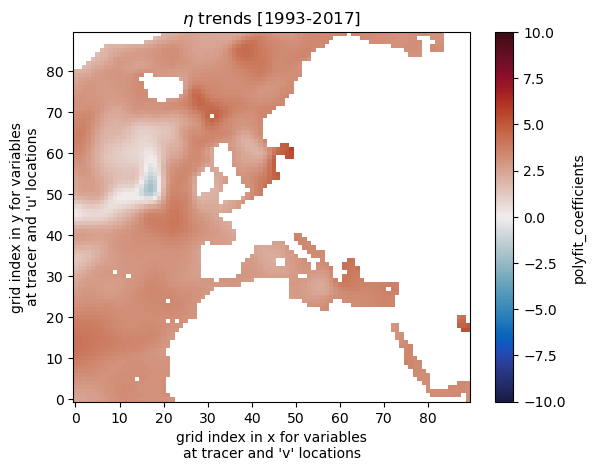

In [83]:
tsel = 2
cb = trend_slope[tsel,:,:].plot(vmin=-10,vmax=10  ,cmap=cmocean.cm.balance)
# plt.pcolor(lon_xc.isel(tile=2),lat_yc.isel(tile=2),trend_slope.isel(tile=2))
plt.title('$\eta$ trends [1993-2017]');

Text(0.5, 1.0, 'SSH trends [1993-2017]')

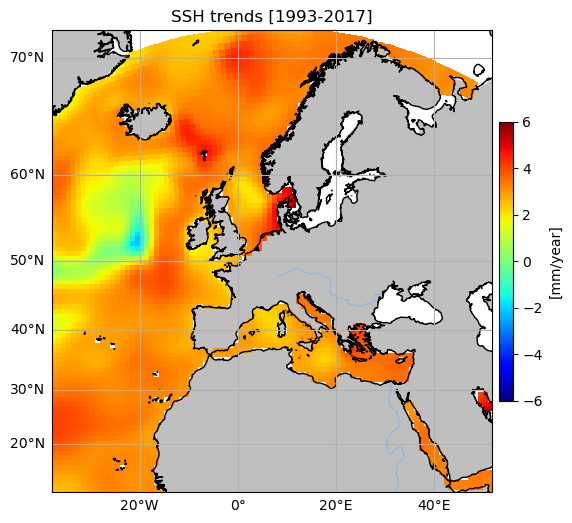

In [99]:
tsel = 2
fig = plt.figure(figsize=[9,6])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(cfeature.RIVERS,facecolor='blue');ax.coastlines('10m')
ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.set_extent([lon_xc[tsel,:,:].min().values,
               lon_xc[tsel,:,:].max().values,
               lat_yc[tsel,:,:].min().values,
               lat_yc[tsel,:,:].max().values],crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False,crs=ccrs.PlateCarree(),x_inline=False,y_inline=False)
gl.xformatter = LONGITUDE_FORMATTER;gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k','rotation':0};
gl.ylabel_style = {'size': 10, 'color': 'k'}
gl.bottom_labels = True; gl.top_labels = False;gl.right_labels = False;gl.left_labels = True



cb = ax.pcolormesh(lon_xc[tsel,:,:].compute(),lat_yc[tsel,:,:].compute(),
                   trend_slope[tsel,:,:],cmap='jet',
                   vmin=-6,vmax=6,
                   transform=ccrs.PlateCarree())
cbar = plt.colorbar(cb,fraction=0.02, pad=0.01, orientation="vertical",
                    shrink=0.75,label='[mm/year]')
plt.title('SSH trends [1993-2017]')

In [100]:
# tsel = 2
# lon_xc[tsel,:,:].min().values

# Computing the nanometric component ($\eta_b$) of $\eta$ (SSH)

In [15]:
eta_b = ds_OBP.OBP[itime,:,:,:].compute() # already  in meter! (m)

In [16]:
eta_b_trends = eta_b.polyfit(dim='time', deg=1, skipna=True)
# The slope (trend) is in the coefficient with degree 1
trend_b_slope = eta_b_trends['polyfit_coefficients'].sel(degree=1)*deltaT*12*1e3#*3.15576*1e16*1e3

<Figure size 1400x600 with 0 Axes>

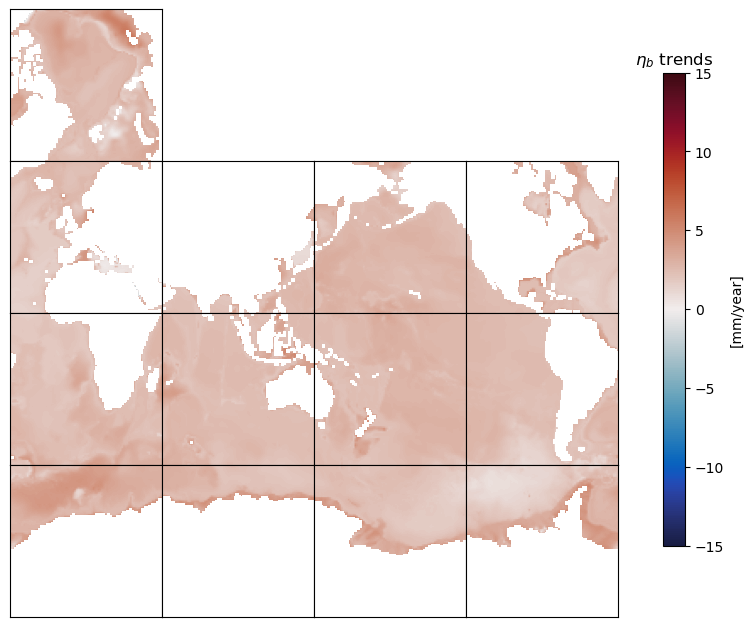

In [17]:
fig = plt.figure(figsize=[14,6]);
ecco.plot_tiles(trend_b_slope, show_colorbar=True, 
                cmin=-15, cmax=15, 
                cmap=cmocean.cm.balance, 
                rotate_to_latlon=True, layout='latlon',
               show_tile_labels=False,show_cbar_label=True, cbar_label='[mm/year]');
plt.title('$\eta_b$ trends');

# Computing the steric component ($\eta_s$) of $\eta$ (SSH)
#  $\eta_s = - \frac{1}{\rho_0}\frac{H+\eta}{H}\int_{-H}^0{\rho'}dz^* $

    
### $dz^* = drF*hFacC$ 

### $H = Depth$ in the Geometry file!
### $\eta = SSH$


## Loading the Geometry file!

In [18]:
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
access_mode = 'download'
# download root (parent) directory
grid_fnm = '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_grid = xr.open_dataset(grid_fnm)
ds_grid

<xarray.Dataset> Size: 92MB
Dimensions:                 (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                             k_l: 50, k_p1: 51, tile: 13, nbh: 4, nv: 2)
Coordinates: (12/20)
  * i                       (i) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * i_g                     (i_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j                       (j) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j_g                     (j_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * k                       (k) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * k_u                     (k_u) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
    ...                      ...
    Zp1                     (k_p1) float32 204B ...
    Zu                      (k_u) float32 200B ...
    Zl                      (k_l) float32 200B ...
    XC_bnds                 (tile, j, i, nbh) float32 2MB ...
    YC_bnds                 (tile, j, i, nbh) float32 2MB ...
    Z_bnds                  (k, nv) float32 400B ...
Dimensions without coordinates: nbh, nv
Data variables: (12/29)
    CS                      (tile, j, i) float32 421kB ...
    SN                      (tile, j, i) float32 421kB ...
    rA                      (tile, j, i) float32 421kB ...
    dxG                     (tile, j_g, i) float32 421kB ...
    dyG                     (tile, j, i_g) float32 421kB ...
    Depth                   (tile, j, i) float32 421kB ...
    ...                      ...
    dyF                     (tile, j, i) float32 421kB ...
    dyU                     (tile, j_g, i_g) float32 421kB ...
    rLowC                   (tile, j, i) float32 421kB ...
    rSurfC                  (tile, j, i) float32 421kB ...
    ocean_column_thickness  (tile, j, i) float32 421kB ...
    ice_shelf_draft         (tile, j, i) float32 421kB ...
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

In [31]:
rhoConst = 1029.
Rho_sum = (ds_grid.drF.compute() * ds_grid.hFacC.compute() * \
           ds_DENS.RHOAnoma[itime,:,:,:].compute()).sum(dim='k')
eta_s = ((-1/rhoConst) * ((ds_grid.Depth.compute() +eta) / ds_grid.Depth.compute())) * Rho_sum
eta_s = eta_s.transpose('time', 'tile', 'j', 'i')
eta_s.dims

('time', 'tile', 'j', 'i')

<Figure size 1400x600 with 0 Axes>

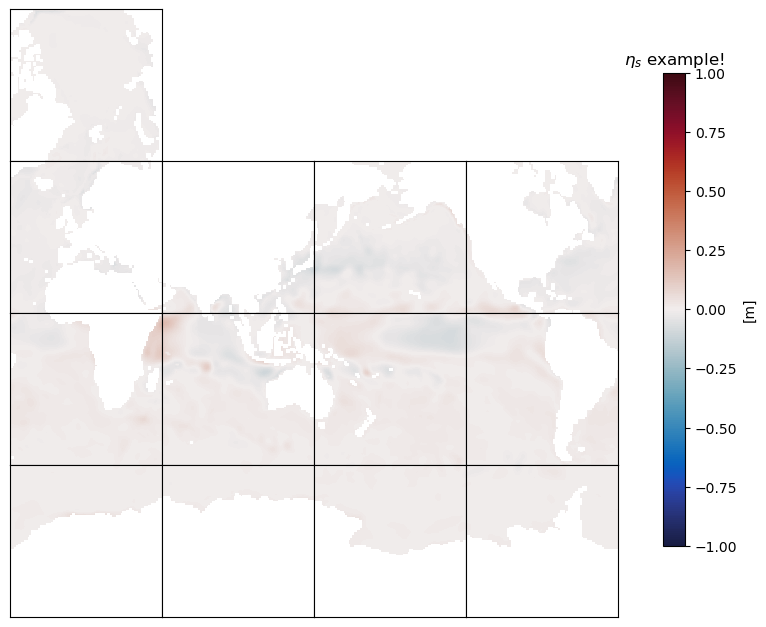

In [32]:
fig = plt.figure(figsize=[14,6]);
ecco.plot_tiles(eta_s[1,:,:,:]-eta_s[0,:,:,:], show_colorbar=True, 
                cmin=-1, cmax=1, 
                cmap=cmocean.cm.balance, 
                rotate_to_latlon=True, layout='latlon',
               show_tile_labels=False,show_cbar_label=True, cbar_label='[m]')
plt.title('$\eta_s$ example!');

# Zoom in the Sub-Polar North Atlantic

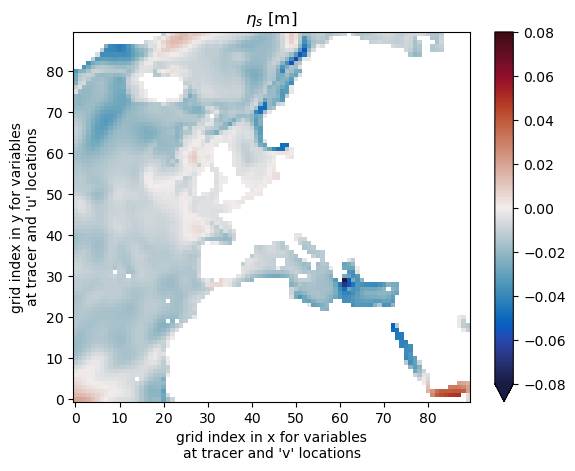

In [48]:
tsel = 2
cb = (eta_s[1,tsel,:,:]-eta_s[0,tsel,:,:]).plot(vmin=-.08,vmax=.08,cmap=cmocean.cm.balance)
# plt.pcolor(lon_xc.isel(tile=2),lat_yc.isel(tile=2),trend_slope.isel(tile=2))
plt.title('$\eta_s$ [m]');

In [60]:
eta_m   = eta.mean(dim='time')
eta_b_m = eta_b.mean(dim='time')
eta_s_m = eta_s.mean(dim='time')
# res = eta - (eta_b+eta_s)
eta_anom   = eta - eta_m
eta_b_anom = eta_b - eta_b_m
eta_s_anom = eta_s - eta_s_m
res_anom   = eta_anom - eta_b_anom - eta_s_anom

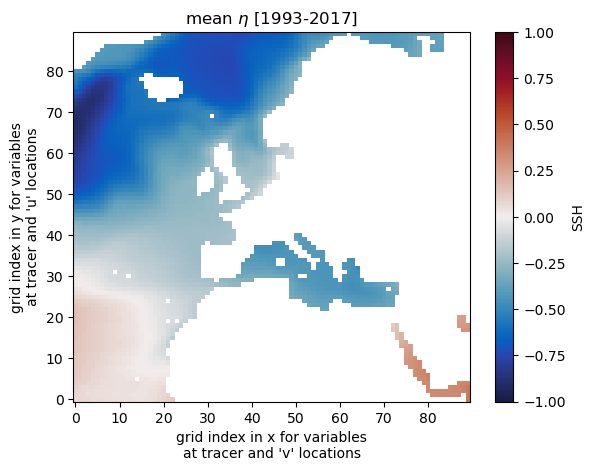

In [59]:
tsel = 2
cb = eta_m[tsel,:,:].plot(vmin=-1,vmax=1,cmap=cmocean.cm.balance)
# plt.pcolor(lon_xc.isel(tile=2),lat_yc.isel(tile=2),trend_slope.isel(tile=2))
plt.title('mean $\eta$ [1993-2017]');

In [72]:
# ds_TS
a=10
b=66
c=55
eta_anom_t   = eta_anom[:,a,b,c]
eta_b_anom_t = eta_b_anom[:,a,b,c]
eta_s_anom_t = eta_s_anom[:,a,b,c]
res_anom_t   = res_anom[:,a,b,c]

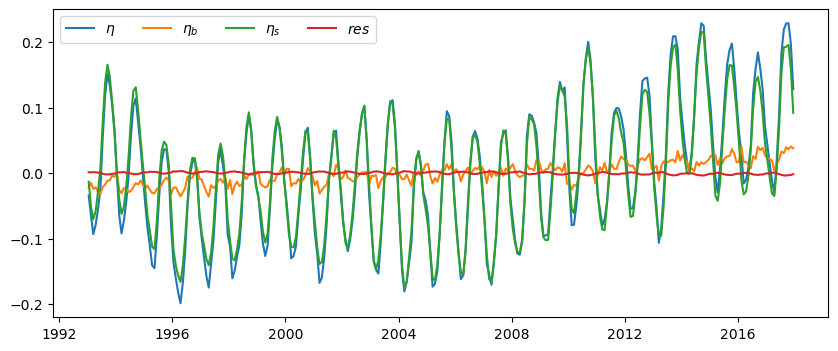

In [82]:
plt.figure(figsize=[10,4])
plt.plot(ds_SSH.time[itime],eta_anom_t,label="$\eta$")
plt.plot(ds_SSH.time[itime],eta_b_anom_t,label="$\eta_b$")
plt.plot(ds_SSH.time[itime],eta_s_anom_t,label="$\eta_s$")
plt.plot(ds_SSH.time[itime],res_anom_t,label="$res$")
plt.legend(ncols=4,loc='upper left')
